# Triode Modeling
* Model Parameter Extraction
* Model Parameter Verification

This experiment uses data extracted from a vacuum tube datasheet and scipy.optimize to calculate the [Child-Langmuir](http://www.john-a-harper.com/tubes201/) parameters used for circuit simulation.

$$I_a = K (V_{gk} + D_aV_{ak})^{3/2}$$

We are going to use curve fitting to determine $$K \text{  and  } D_A$$ 

Then we can use [Leach's triode](users.ece.gatech.edu/mleach/papers/tubeamp/tubeamp.pdf) SPICE model.

In [11]:
import scipy
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import math

Starting with the [Philips ECC83 data sheet](data/ecc83-philips-1954.pdf), create a PNG of the 
![ECC83 Philips 1953](data/ecc83-philips-1954.png)
import this image into [engauge](https://github.com/markummitchell/engauge-digitizer)

Create 9 curves then use 'curve point tool' to add points to each curve
![ecc83-philips-1954.dig.screen1.png](data/ecc83-philips-1954.dig.screen1.png)

Change export options, "Raw Xs and Ys" and "One curve on each line", otherwise engauge will do some interrupting of your points
![ecc83-philips-1954.dig.screen2.png](data/ecc83-philips-1954.dig.screen2.png)
export a csv file

In [2]:
%cat data/ecc83-philips-1954.csv


x,Curve1
2.26,0.0001626
9.41,0.0003321
14.94,0.0004691
22.1,0.0005997
28.27,0.0007562
38.35,0.0009455
46.82,0.0010698
54.63,0.001207
65.69,0.0013899
77.07,0.0016054
86.5,0.0018142
103.09,0.0021795
124.87,0.0026818
146.98,0.0031906
166.16,0.0036406
183.06,0.0040515
199.96,0.0044558
216.87,0.0048537

x,Curve2
7.17,3.97e-05
14.66,9.24e-05
23.13,0.0001582
31.28,0.0002175
38.11,0.0003156
43.65,0.0003747
53.09,0.0004795
61.23,0.0005908
71.64,0.0007412
80.76,0.000872
97.35,0.0011335
113.62,0.0014144
129.88,0.0017278
147.77,0.0021063
163.37,0.0024585
180.61,0.0028564
195.56,0.0031956
208.89,0.0035152
223.84,0.0038674
236.85,0.0041869
249.19,0.0045064

x,Curve3
12.39,-1.82e-05
24.46,-4e-06
30.65,9.7e-06
36.84,2.98e-05
43.69,5.65e-05
50.53,8.97e-05
61.94,0.0001558
74.32,0.0002285
82.46,0.0002878
88,0.0003598
101.02,0.0004845
113.39,0.0006417
125.11,0.0007922
136.5,0.0009817
153.42,0.0012692
177.81,0.0017587
201.23,0.0022417
223.67,0.0027245
246.75,0.0032464
268.54,0.0037162

x,Curve4
8.15,-1.21e

Need to create scipy array like this

x = scipy.array([[0,150],[-3.0,300],[-1.0,200],[-2.0,250]])

y = scipy.array([3.2e-3,0.6e-3,2.2e-3,1.2e-3])

from the extracted curves

In [29]:
fname = "data/ecc83-philips-1954.csv"
f = open(fname,'r').readlines()

deltaVgk = -0.5

VgkVak = []
Iak    = []
Vaks   = []

for l in f:
    l = l.strip()
    if len(l): # skip blank lines
        if l[0] == 'x':
            vn = float(l.split("Curve")[1]) - 1.0
            Vgk = vn * deltaVgk
            continue
        else:
            (Vak,i) = l.split(',')
        VgkVak.append([float(Vgk),float(Vak)])
        Iak.append(float(i))
        Vaks.append(float(Vak))

x = scipy.array(VgkVak)
y = scipy.array(Iak)
Vaks = scipy.array(Vaks)

In [4]:
%matplotlib inline
exp = 1.5

def func(x,K,Da):
    rv = []
    for VV in x:
        Vgk = VV[0]
        Vak = VV[1]
        t = Vgk + Da * Vak

        if t > 0:
            Ia = K * t**exp
        else:
            Ia = 0
        # print "IaCalc",Vgk,Vak,t,Ia
        rv.append(Ia)

    return rv

popt, pcov = curve_fit(func, x, y,p0=[0.001,0.01])
#print popt,pcov

(K,Da) = popt

print "K=%.8f   Da=%.8f"%(K,Da)



K=0.00126098   Da=0.01179251


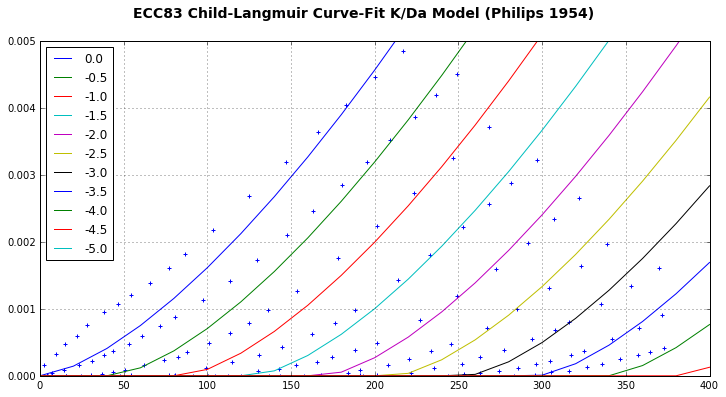

In [5]:
def IaCalc(Vgk,Vak):
    t = Vgk + Da * Vak
    if t > 0:
        Ia = K * t**exp
    else:
        Ia = 0
    # print "IaCalc",Vgk,Vak,t,Ia
    return Ia

Vgk = np.linspace(0,-5,11)
Vak = np.linspace(0,400,21)

vIaCalc = np.vectorize(IaCalc,otypes=[np.float])

Ia = vIaCalc(Vgk[:,None],Vak[None,:])

plt.figure(figsize=(12,6))

for i in range(len(Vgk)):
    plt.plot(Vak,Ia[i],label=Vgk[i])

plt.scatter(Vaks,y,marker="+")
plt.legend(loc='upper left')
plt.suptitle('ECC83 Child-Langmuir Curve-Fit K/Da Model (Philips 1954)', fontsize=14, fontweight='bold')
plt.grid()
plt.ylim((0,0.005))
plt.xlim((0,400))
#plt.savefig("ecc83-philips-1954-curvefit.png")
plt.show()

Trying the [Koren's triode](http://www.normankoren.com/Audio/Tubemodspice_article.html) phenomenological model.

$$E_1 = \frac{E_P}{k_P} 
log\left(1 + exp^{k_P (\frac{1}{u} + \frac{E_G}{\sqrt{k_{VB} + {E_P}^2}})}\right)$$

$$I_P = \left(\frac{{E_1}^X}{k_{G1}}\right) \left(1+sgn(E_1)\right)$$

Need to fit $X, k_{G1}, k_P, k_{VB}$

In [56]:
mu = 100

def sgn(val):
    if val >= 0:
        return 1
    if val < 0:
        return -1
    
def funcKoren(x,X,kG1,kP,kVB):
    rv = []
    for VV in x:
        EG = VV[0]
        EP = VV[1]
        
        E1 = (EP/kP) * math.log(1 + math.exp(kP*(1/mu + EG / math.sqrt(kVB + EP*EP)))) 
        if E1 > 0:
            IP = (math.pow(E1,X)/kG1)*(1 + sgn(E1))
        else:
            IP = 0
        rv.append(IP)

    return rv

popt, pcov = curve_fit(funcKoren,x,y,p0=[1.3,1000,610,305])
#print popt,pcov

(X,kG1,kP,kVB) = popt

print "X=%.8f   kG1=%.8f   kP=%.8f   kVB=%.8f"%(X,kG1,kP,kVB)

# koren's values 12AX7 mu=100 X=1.4 kG1=1060 kP=600 kVB=300


X=1.25013759   kG1=191.63052993   kP=249.11435609   kVB=24953.24402839


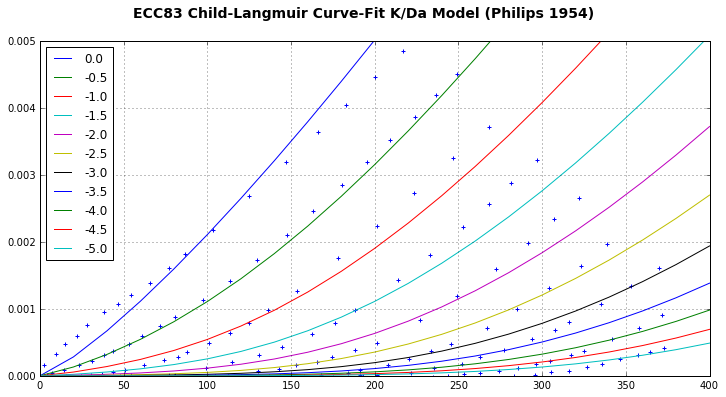

In [57]:
'''
X=1.4
kG1=1060
kP=600
kVB=300
mu=100
'''

def IaCalcKoren(Vgk,Vak):
    global X,kG1,kP,kVB,mu
    E1 = (Vak/kP) * math.log(1 + math.exp(kP*(1/mu + Vgk / math.sqrt(kVB + Vak*Vak)))) 
    Ia = (math.pow(E1,X)/kG1)*(1 + sgn(E1))
    return Ia

Vgk = np.linspace(0,-5,11)
Vak = np.linspace(0,400,21)

vIaCalcKoren = np.vectorize(IaCalcKoren,otypes=[np.float])

Ia = vIaCalcKoren(Vgk[:,None],Vak[None,:])

plt.figure(figsize=(12,6))

for i in range(len(Vgk)):
    plt.plot(Vak,Ia[i],label=Vgk[i])

plt.scatter(Vaks,y,marker="+")
plt.legend(loc='upper left')
plt.suptitle('ECC83 Child-Langmuir Curve-Fit Koren Model (Philips 1954)', fontsize=14, fontweight='bold')
plt.grid()
plt.ylim((0,0.005))
plt.xlim((0,400))
#plt.savefig("ecc83-philips-1954-curvefit.png")
plt.show()